In [2]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import pandas as pd

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
devices = tf.config.list_physical_devices('GPU')
print(len(devices)) 

1


In [3]:
img_df = pd.read_csv("photos/image_labels.csv")
img_df.head()

,path,class,label,image_id
0,one_1.jpg,one,0,11
1,one_10.jpg,one,0,11
2,one_11.jpg,one,0,11
3,one_12.jpg,one,0,11
4,one_13.jpg,one,0,11


In [4]:
len(img_df)

899

### Resize images

In [98]:
from PIL import Image

(new_width, new_height) = (128, 128)

path = "photos/original/"
filenames = img_df["path"]

for filename in filenames:
    with Image.open(f"{path}/{filename}") as im:
        width, height = im.size
        if height >= width:
            left = 0
            top = (height-width)/2
            right = width
            bottom = width+(height-width)/2
        else:
            left = (width-height)/2
            top = 0
            right = height+(width-height)/2
            bottom = height
        im_cropped = im.crop((left, top, right, bottom))
        im_resized = im_cropped.resize((new_width, new_height), resample=Image.HAMMING)
        im_resized.save(f"photos/resized/128/{filename}")

### Create dataset

In [99]:
filenames = img_df["path"]
labels = img_df["label"]
classes = ["one", "two", "three", "four", "five", "six", "seven", "eight", "nine", 
           "Alphabet_A", "Alphabet_B", "Alphabet_C", "Alphabet_D", "Alphabet_E", "Alphabet_F", "Alphabet_G", "Alphabet_H", "Alphabet_S", "Alphabet_T", "Alphabet_U", "Alphabet_v", "Alphabet_w", "Alphabet_x", "Alphabet_y", "Alphabet_z", 
           "up_arrow", "down_arrow", "right_arrow", "left_arrow", "Stop", "Bullseye"]

In [100]:
def decode_images(file):
  path = f"./photos/resized/128/{file}"
  print(path)
  image_decoded = tf.image.decode_jpeg(tf.io.read_file(path), channels=3)/255
  im = tf.cast(image_decoded, tf.float32)
  return im

decoded_images = list(map(lambda file: decode_images(file), list(filenames)))

./photos/resized/128/one_1.jpg
./photos/resized/128/one_10.jpg
./photos/resized/128/one_11.jpg
./photos/resized/128/one_12.jpg
./photos/resized/128/one_13.jpg
./photos/resized/128/one_14.jpg
./photos/resized/128/one_15.jpg
./photos/resized/128/one_16.jpg
./photos/resized/128/one_17.jpg
./photos/resized/128/one_18.jpg
./photos/resized/128/one_19.jpg
./photos/resized/128/one_2.jpg
./photos/resized/128/one_3.jpg
./photos/resized/128/one_4.jpg
./photos/resized/128/one_5.jpg
./photos/resized/128/one_6.jpg
./photos/resized/128/one_7.jpg
./photos/resized/128/one_8.jpg
./photos/resized/128/one_9.jpg
./photos/resized/128/one_20.jpg
./photos/resized/128/one_21.jpg
./photos/resized/128/one_22.jpg
./photos/resized/128/one_23.jpg
./photos/resized/128/one_24.jpg
./photos/resized/128/one_25.jpg
./photos/resized/128/one_26.jpg
./photos/resized/128/one_27.jpg
./photos/resized/128/one_28.jpg
./photos/resized/128/one_29.jpg
./photos/resized/128/two_1.jpg
./photos/resized/128/two_10.jpg
./photos/resized/1

In [101]:
print(decoded_images[1])

tf.Tensor(
[[[0.58431375 0.50980395 0.48235294]
  [0.5803922  0.5058824  0.47843137]
  [0.57254905 0.49803922 0.47058824]
  ...
  [0.75686276 0.7882353  0.83137256]
  [0.8156863  0.84705883 0.8901961 ]
  [0.91764706 0.9490196  0.99215686]]

 [[0.5803922  0.5058824  0.47843137]
  [0.5764706  0.5019608  0.4745098 ]
  [0.57254905 0.49803922 0.47058824]
  ...
  [0.91764706 0.9490196  0.99215686]
  [0.92156863 0.9529412  0.99607843]
  [0.9607843  0.99215686 1.        ]]

 [[0.5764706  0.5019608  0.4745098 ]
  [0.57254905 0.49803922 0.47058824]
  [0.5686275  0.49411765 0.46666667]
  ...
  [0.74509805 0.78431374 0.83137256]
  [0.68235296 0.72156864 0.7607843 ]
  [0.654902   0.69411767 0.73333335]]

 ...

 [[0.29803923 0.31764707 0.33333334]
  [0.29803923 0.31764707 0.33333334]
  [0.29411766 0.3137255  0.32941177]
  ...
  [0.7294118  0.7607843  0.7176471 ]
  [0.7294118  0.7607843  0.7176471 ]
  [0.7294118  0.7607843  0.7176471 ]]

 [[0.29803923 0.31764707 0.33333334]
  [0.29803923 0.31764707 0

In [102]:
labels = tf.constant(labels)

In [103]:
print(labels)

tf.Tensor(
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  3  3  3  3  3  3  3  3  3
  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  4  4  4  4
  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4
  4  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5
  5  5  5  5  5  5  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6
  6  6  6  6  6  6  6  6  6  6  6  7  7  7  7  7  7  7  7  7  7  7  7  7
  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  8  8  8  8  8  8  8  8
  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  9  9  9
  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9
  9  9 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10
 10 10 10 10 10 10 10 11 11 11 11 11 11 

In [104]:
dataset = tf.data.Dataset.from_tensor_slices((decoded_images, labels))

In [105]:
len(dataset)

899

In [106]:
dataset = dataset.shuffle(900)

In [107]:
dataset

<ShuffleDataset element_spec=(TensorSpec(shape=(128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

Text(0.5, 1.0, 'four')

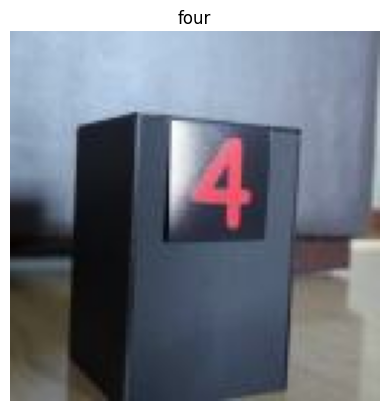

In [108]:
image, label = next(iter(dataset))
plt.imshow(image)
plt.axis("off")
plt.title(classes[label])

In [109]:
path = "./datasets/original_128"

dataset.save(path)

### Data augmentation

In [70]:
path = "./datasets/original_128"

dataset = tf.data.Dataset.load(path)


In [71]:
len(dataset)

899

In [72]:
dataset = dataset.shuffle(900)

In [73]:
classes = ["one", "two", "three", "four", "five", "six", "seven", "eight", "nine", 
           "Alphabet_A", "Alphabet_B", "Alphabet_C", "Alphabet_D", "Alphabet_E", "Alphabet_F", "Alphabet_G", "Alphabet_H", "Alphabet_S", "Alphabet_T", "Alphabet_U", "Alphabet_v", "Alphabet_w", "Alphabet_x", "Alphabet_y", "Alphabet_z", 
           "up_arrow", "down_arrow", "right_arrow", "left_arrow", "Stop", "Bullseye"]

In [74]:
data_augmentation = keras.Sequential(
  [
    layers.RandomZoom(0.3, fill_mode="nearest"),
    layers.RandomRotation(0.01, fill_mode="nearest"),
    layers.RandomBrightness(0.0005),
    layers.RandomContrast(0.0005)
  ]
)

Text(0.5, 1.0, 'one')

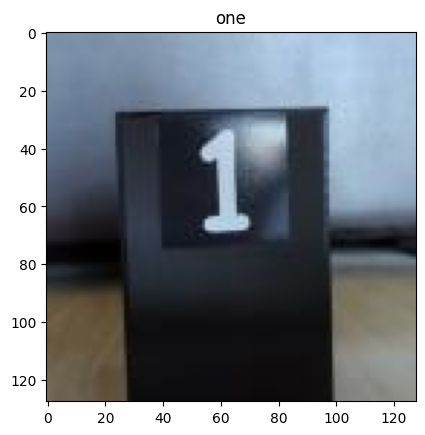

In [75]:
image, label = next(iter(dataset))
plt.imshow(image)
plt.title(classes[label])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


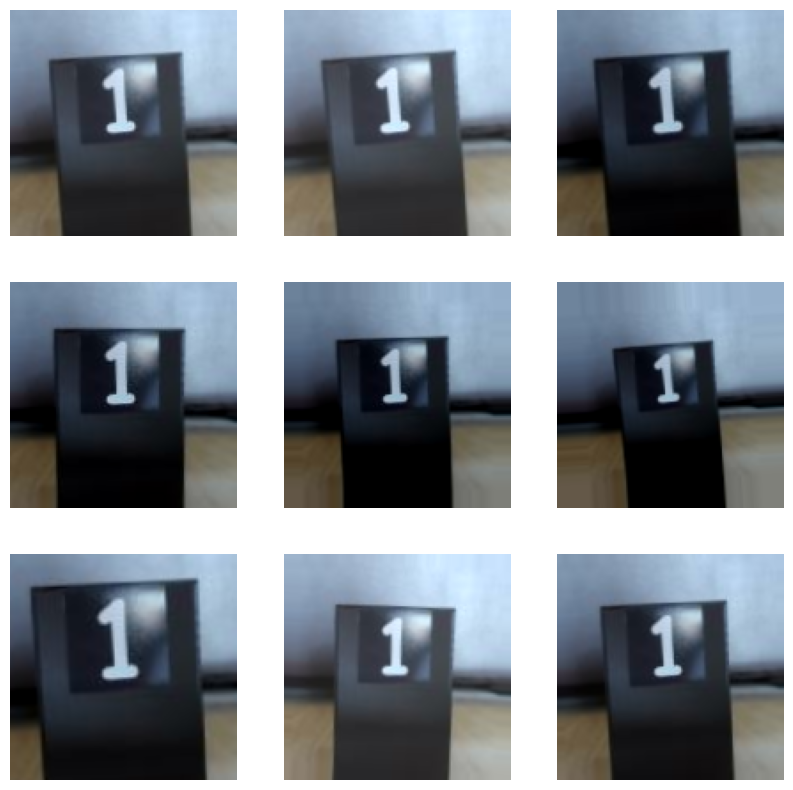

In [76]:
plt.figure(figsize=(10, 10))
for i in range(9):
  new_image = data_augmentation(image)
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(new_image)
  plt.axis("off")

In [77]:
for i in range(10):
    new_images = tf.reshape(tf.constant([], dtype=tf.dtypes.float32), (0, 128, 128, 3))
    new_labels = tf.reshape(tf.constant([], dtype=tf.dtypes.int64), (0))    
    for image, label in dataset:
        new_image = data_augmentation(image)
        new_images = tf.concat([new_images,  tf.expand_dims(new_image, 0)], axis=0)
        new_labels = tf.concat([new_labels, tf.expand_dims(label, 0)], axis=0)
    if i == 0:
        add_dataset = tf.data.Dataset.from_tensor_slices((new_images, new_labels))
    else:
        temp_dataset = tf.data.Dataset.from_tensor_slices((new_images, new_labels))
        add_dataset = add_dataset.concatenate(temp_dataset)
    print(f"Iteration {i+1}")


Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9
Iteration 10


In [79]:
dataset = dataset.concatenate(add_dataset)

In [80]:
print(len(dataset))

9889


In [81]:
dataset = dataset.shuffle(10000)

Text(0.5, 1.0, 'Stop')

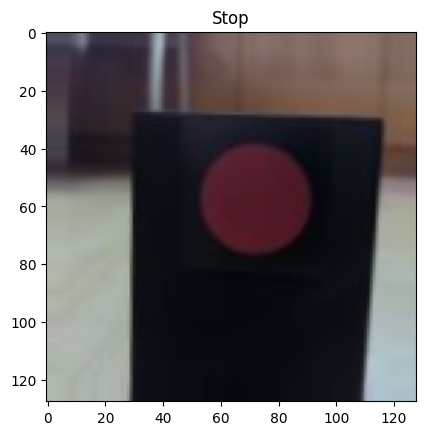

In [104]:
image, label = next(iter(dataset))
plt.imshow(image)
plt.title(classes[label])

In [105]:
print(image)

tf.Tensor(
[[[0.29930273 0.31105947 0.3777128 ]
  [0.29930273 0.31105947 0.3777128 ]
  [0.29930273 0.31105947 0.3777128 ]
  ...
  [0.5031784  0.4247594  0.38947484]
  [0.5031784  0.4247594  0.38947484]
  [0.5031784  0.4247594  0.38947484]]

 [[0.29930273 0.31105947 0.3777128 ]
  [0.29930273 0.31105947 0.3777128 ]
  [0.29930273 0.31105947 0.3777128 ]
  ...
  [0.5031784  0.4247594  0.38947484]
  [0.5031784  0.4247594  0.38947484]
  [0.5031784  0.4247594  0.38947484]]

 [[0.29930273 0.31105947 0.3777128 ]
  [0.29930273 0.31105947 0.3777128 ]
  [0.29930273 0.31105947 0.3777128 ]
  ...
  [0.5031784  0.4247594  0.38947484]
  [0.5031784  0.4247594  0.38947484]
  [0.5031784  0.4247594  0.38947484]]

 ...

 [[0.69137144 0.7188109  0.6874471 ]
  [0.69137144 0.7188109  0.6874471 ]
  [0.69137144 0.7188109  0.6874471 ]
  ...
  [0.67960936 0.7540971  0.78154355]
  [0.67960936 0.7540971  0.78154355]
  [0.67960936 0.7540971  0.78154355]]

 [[0.69137144 0.7188109  0.6874471 ]
  [0.69137144 0.7188109  0

In [106]:
path = "./datasets/full_128"

dataset.save(path)

### Train-test-val split

In [77]:
path = "./datasets/full_128"

full_dataset = tf.data.Dataset.load(path)


In [78]:
classes = ["one", "two", "three", "four", "five", "six", "seven", "eight", "nine", 
           "Alphabet_A", "Alphabet_B", "Alphabet_C", "Alphabet_D", "Alphabet_E", "Alphabet_F", "Alphabet_G", "Alphabet_H", "Alphabet_S", "Alphabet_T", "Alphabet_U", "Alphabet_v", "Alphabet_w", "Alphabet_x", "Alphabet_y", "Alphabet_z", 
           "up_arrow", "down_arrow", "right_arrow", "left_arrow", "Stop", "Bullseye"]

In [79]:
len(full_dataset)

3596

In [80]:
full_dataset = full_dataset.shuffle(3600)

In [81]:
val_size = test_size = int(0.15*len(full_dataset))
train_size = len(full_dataset) - val_size - test_size

train_dataset = full_dataset.take(train_size)
test_dataset = full_dataset.skip(train_size)
val_dataset = test_dataset.skip(val_size)
test_dataset = test_dataset.take(test_size)

print(len(train_dataset), len(val_dataset), len(test_dataset))

2518 539 539


In [82]:
#check if all datasets contain all classes
train_labels = []
for image, label in train_dataset:
    train_labels.append(int(label))

print(len(np.unique(train_labels)))

val_labels = []
for image, label in val_dataset:
    val_labels.append(int(label))

print(len(np.unique(val_labels)))

test_labels = []
for image, label in test_dataset:
    test_labels.append(int(label))

print(len(np.unique(test_labels)))

31
31
31


In [83]:
batch_size = 32

train_dataset = train_dataset.batch(batch_size)
val_dataset = val_dataset.batch(batch_size)
test_dataset = test_dataset.batch(batch_size)

In [84]:
train_dataset

<BatchDataset element_spec=(TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

### CNN

In [86]:
img_shape = (64, 64, 3)

In [87]:
data_augmentation = keras.Sequential(
  [
    layers.RandomZoom(0.3, fill_mode="nearest"),
    layers.RandomRotation(0.01, fill_mode="nearest"),
    layers.RandomBrightness(0.0005),
    layers.RandomContrast(0.0005)
  ]
)

In [90]:
cnn_model = Sequential([
  keras.Input(shape=img_shape),
  data_augmentation,
  layers.DepthwiseConv2D(3, 1, depth_multiplier=1, activation='relu'),
  layers.MaxPooling2D(2, 2),
  layers.DepthwiseConv2D(3, 1, depth_multiplier=1, activation='relu'),
  layers.MaxPooling2D(2, 2),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(224, activation='relu'),
  layers.Dense(len(classes))
])


In [86]:
cnn_model = Sequential([
  keras.Input(shape=(224, 224, 3)),
  data_augmentation,
  layers.Conv2D(12, 5, activation='relu'),
  layers.MaxPooling2D(3, 3),
  layers.Conv2D(24, 5, activation='relu'),
  layers.MaxPooling2D(3, 3),
  layers.Conv2D(48, 5, activation='relu'),
  layers.MaxPooling2D(3, 3),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(224, activation='relu'),
  layers.Dense(len(classes))
])


In [91]:
import tensorflow_addons as tfa

optimizer = tfa.optimizers.AdamW(weight_decay=0.004, learning_rate=0.001)
#optimizer = keras.optimizers.Adam(learning_rate=0.001)

c:\Users\waiho\Documents\Python_venv\AI_ML_env\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
c:\Users\waiho\Documents\Python_venv\AI_ML_env\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.12.0 and strictly below 2.15.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.10.1 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do no

In [92]:
cnn_model.compile(optimizer=optimizer,
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])

In [93]:
cnn_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (None, 64, 64, 3)         0         
                                                                 
 depthwise_conv2d_3 (Depthwi  (None, 62, 62, 3)        30        
 seConv2D)                                                       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 31, 31, 3)        0         
 2D)                                                             
                                                                 
 depthwise_conv2d_4 (Depthwi  (None, 29, 29, 3)        30        
 seConv2D)                                                       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 14, 14, 3)        0         
 2D)                                                  

In [94]:
epochs = 20

history = cnn_model.fit(
  train_dataset,
  validation_data=val_dataset,
  epochs=epochs
)

Epoch 1/20


79/79 [==============================] - 27s 273ms/step - loss: 3.4232 - accuracy: 0.0437 - val_loss: 3.4032 - val_accuracy: 0.0371
Epoch 2/20
79/79 [==============================] - 22s 269ms/step - loss: 3.3241 - accuracy: 0.0635 - val_loss: 3.1943 - val_accuracy: 0.1113
Epoch 3/20
79/79 [==============================] - 22s 269ms/step - loss: 3.2082 - accuracy: 0.0786 - val_loss: 3.1515 - val_accuracy: 0.1058
Epoch 4/20
79/79 [==============================] - 22s 269ms/step - loss: 3.1312 - accuracy: 0.0937 - val_loss: 3.0316 - val_accuracy: 0.1317
Epoch 5/20
79/79 [==============================] - 22s 270ms/step - loss: 3.1167 - accuracy: 0.0850 - val_loss: 3.0725 - val_accuracy: 0.0909
Epoch 6/20
79/79 [==============================] - 21s 268ms/step - loss: 3.1044 - accuracy: 0.0890 - val_loss: 3.0200 - val_accuracy: 0.1280
Epoch 7/20
79/79 [==============================] - 21s 268ms/step - loss: 3.0949 - accuracy: 0.0989 - val_loss: 3.0100 - val_accuracy: 0.1410
Epoch 8/20

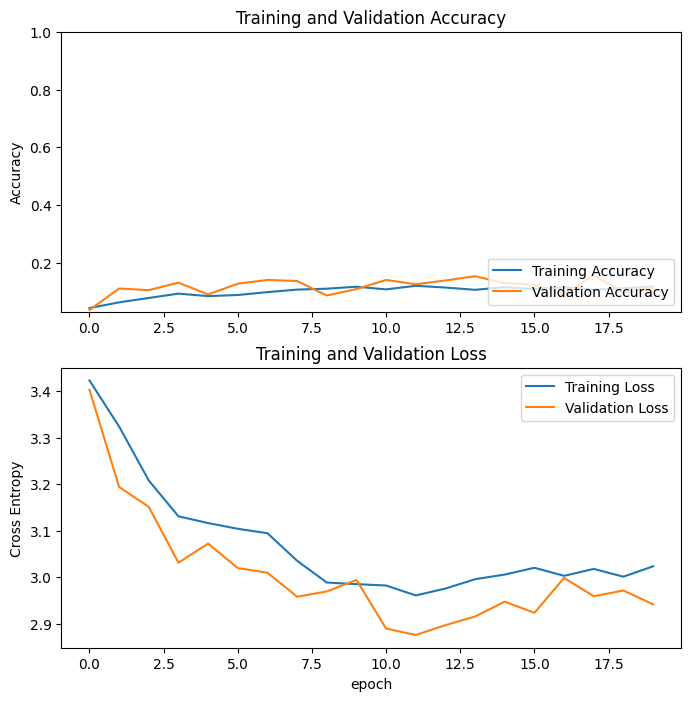

In [95]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [96]:
results = cnn_model.evaluate(test_dataset, batch_size=32)
print("test loss, test acc:", results)

17/17 [==============================] - 0s 3ms/step - loss: 2.9361 - accuracy: 0.1317
test loss, test acc: [2.9361188411712646, 0.13172541558742523]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


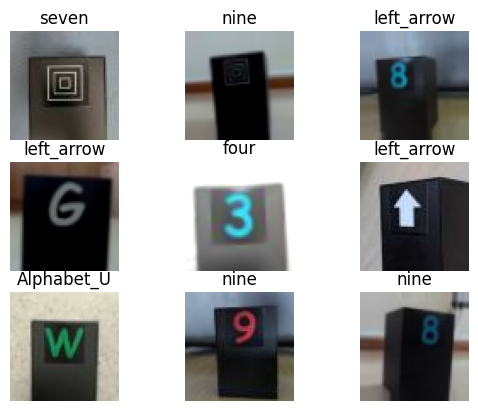

In [97]:
images, labels = next(iter(test_dataset))
preds = cnn_model(images)
preds = tf.math.argmax(preds, 1).numpy()

for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    plt.title(classes[int(preds[i])])
    plt.axis("off")

In [160]:
total_history_dict = dict()

for some_key in history.history.keys():
    current_values = [] # to save values from all history dicts
    for hist_dict in [history.history, history1.history]:
        current_values += hist_dict[some_key]
    total_history_dict[some_key] = current_values

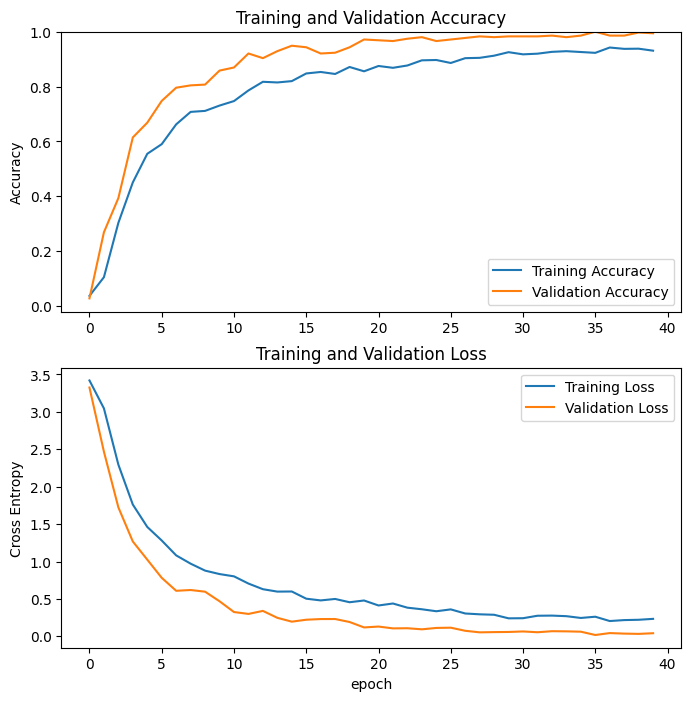

In [161]:
acc = total_history_dict['accuracy']
val_acc = total_history_dict['val_accuracy']

loss = total_history_dict['loss']
val_loss = total_history_dict['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### Finetune pretrained model

In [94]:
img_shape = (224, 224, 3)

In [96]:
mobnetv3 = keras.applications.MobileNetV3Small(
  input_shape=img_shape,
  classes=len(classes),
  include_top=False,
  weights='imagenet',
  pooling=None,
  include_preprocessing=True
)

In [97]:
mobnetv3.summary()

Model: "MobilenetV3small"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_9[0][0]']                
                                                                                                  
 Conv (Conv2D)                  (None, 112, 112, 16  432         ['rescaling[0][0]']              
                                )                                                                 
                                                                                   

In [98]:
len(mobnetv3.layers)

229

In [99]:
for layer in mobnetv3.layers:
    layer.trainable = True


In [104]:
data_augmentation = keras.Sequential(
  [
    layers.RandomZoom(0.3, fill_mode="nearest"),
    layers.RandomRotation(0.01, fill_mode="nearest"),
    layers.RandomBrightness(0.0005),
    layers.RandomContrast(0.0005)
  ]
)

In [105]:
mobnetv3_ft = keras.Sequential([
  keras.Input(shape=(224, 224, 3)), 
  data_augmentation,
  layers.Rescaling(255),
  mobnetv3,
  layers.GlobalAveragePooling2D(),
  layers.Dropout(0.2),
  layers.Dense(128, activation="relu"),
  layers.Dense(len(classes))
])

In [106]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = mobnetv3_ft(image_batch)
print(feature_batch.shape)

(32, 31)


In [107]:
feature_batch

<tf.Tensor: shape=(32, 31), dtype=float32, numpy=
array([[ 5.62798083e-01, -5.89992344e-01, -1.34305859e+00,
        -1.24746370e+00,  2.24179953e-01,  1.12571192e+00,
        -5.94169617e-01, -7.50460744e-01,  2.68258512e-01,
         6.62184000e-01,  5.05667925e-03, -8.05406034e-01,
        -5.95690072e-01, -1.19655892e-01,  1.99379325e-01,
        -2.01203182e-01, -6.63489342e-01,  3.07266772e-01,
        -1.00771725e+00, -4.39041048e-01,  5.95531821e-01,
        -2.28753075e-01,  3.07001412e-01, -6.84134245e-01,
        -2.07354575e-01,  6.70051217e-01,  1.17509639e+00,
         7.18639970e-01, -1.41987526e+00, -2.81846881e-01,
         4.46826577e-01],
       [-6.33039415e-01, -1.97393268e-01, -1.27181125e+00,
        -4.61394548e-01,  1.63468122e-02,  1.42073274e+00,
        -8.21337327e-02, -6.72025323e-01,  5.29913604e-02,
         5.03547311e-01, -3.97742271e-01, -4.17347074e-01,
        -1.14711523e+00, -4.78936583e-01,  1.02005029e+00,
        -3.59033108e-01, -9.72595513e-0

In [108]:
mobnetv3_ft.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_13 (Sequential)  (None, 224, 224, 3)       0         
                                                                 
 rescaling_3 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 MobilenetV3small (Functiona  (None, 7, 7, 576)        939120    
 l)                                                              
                                                                 
 global_average_pooling2d_2   (None, 576)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_10 (Dropout)        (None, 576)               0         
                                                                 
 dense_20 (Dense)            (None, 128)             

In [109]:
import tensorflow_addons as tfa

#optimizer = keras.optimizers.Adam(learning_rate=0.0001)
optimizer = tfa.optimizers.AdamW(weight_decay=0.004, learning_rate=0.0001)

In [110]:
mobnetv3_ft.compile(optimizer=optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [111]:
epochs = 30

history_mobnet = mobnetv3_ft.fit(train_dataset,
                    epochs=epochs,
                    validation_data=val_dataset)

Epoch 1/30


79/79 [==============================] - 37s 355ms/step - loss: 3.3020 - accuracy: 0.1350 - val_loss: 3.4311 - val_accuracy: 0.0371
Epoch 2/30
79/79 [==============================] - 30s 353ms/step - loss: 2.7771 - accuracy: 0.4615 - val_loss: 3.4330 - val_accuracy: 0.0315
Epoch 3/30
79/79 [==============================] - 30s 354ms/step - loss: 2.4704 - accuracy: 0.6108 - val_loss: 3.4335 - val_accuracy: 0.0334
Epoch 4/30
79/79 [==============================] - 29s 347ms/step - loss: 2.4922 - accuracy: 0.6390 - val_loss: 3.4406 - val_accuracy: 0.0315
Epoch 5/30
79/79 [==============================] - 29s 348ms/step - loss: 2.6715 - accuracy: 0.5608 - val_loss: 3.4484 - val_accuracy: 0.0186
Epoch 6/30
79/79 [==============================] - 30s 346ms/step - loss: 2.8239 - accuracy: 0.4770 - val_loss: 3.4630 - val_accuracy: 0.0223
Epoch 7/30
79/79 [==============================] - 29s 346ms/step - loss: 2.9902 - accuracy: 0.3876 - val_loss: 3.4553 - val_accuracy: 0.0315
Epoch 8/30

KeyboardInterrupt: 

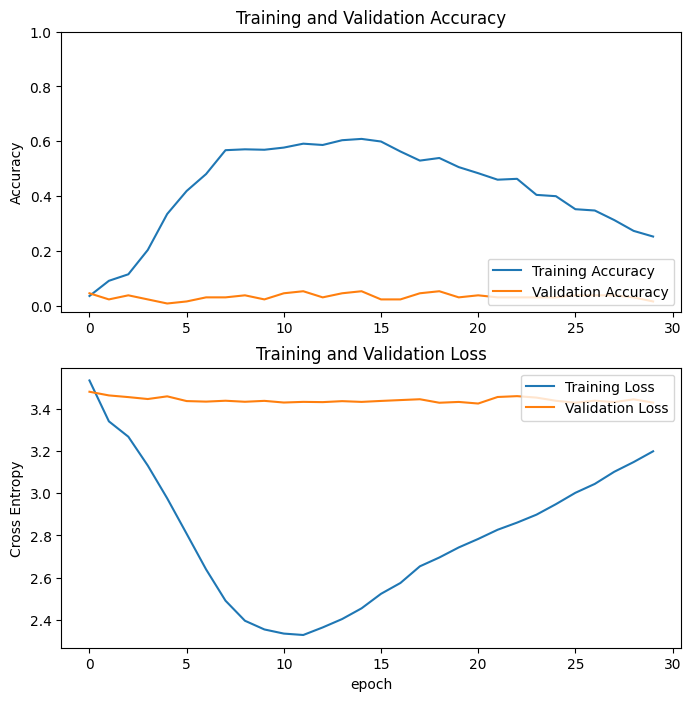

In [79]:
acc = history_mobnet.history['accuracy']
val_acc = history_mobnet.history['val_accuracy']

loss = history_mobnet.history['loss']
val_loss = history_mobnet.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [176]:
loss, accuracy = mobnetv3_ft.evaluate(test_dataset)
print('Test accuracy :', accuracy)

12/12 [==============================] - 2s 21ms/step - loss: 3.4340 - accuracy: 0.0170
Test accuracy : 0.016997167840600014


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


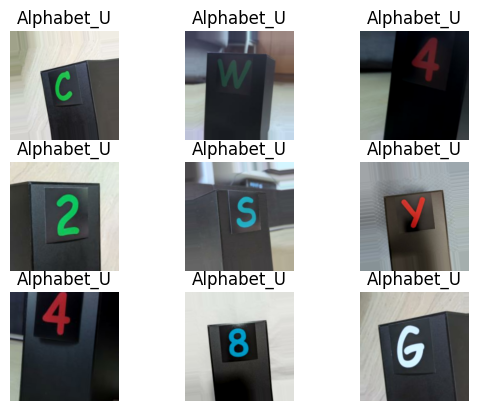

In [177]:
images, labels = next(iter(test_dataset))
preds = mobnetv3_ft(images)
preds = tf.math.argmax(preds, 1).numpy()

for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    plt.title(classes[int(preds[i])])
    plt.axis("off")

In [109]:
preds

array([11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11,
       11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11],
      dtype=int64)

##### effnet

In [180]:
effnetv2 = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(
    include_top=False,
    weights='imagenet',
    input_shape=img_shape,
    include_preprocessing=True
)

In [181]:
effnetv2.trainable = True

In [182]:
effnetv2.summary()

Model: "efficientnetv2-b0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_23 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_11 (Rescaling)       (None, 224, 224, 3)  0           ['input_23[0][0]']               
                                                                                                  
 normalization_4 (Normalization  (None, 224, 224, 3)  0          ['rescaling_11[0][0]']           
 )                                                                                                
                                                                                  

In [183]:
effnetv2_ft = keras.Sequential([
  keras.Input(shape=(224, 224, 3)), 
  data_augmentation,
  layers.Rescaling(255),
  effnetv2,
  layers.GlobalAveragePooling2D(),
  layers.Dropout(0.5),
  layers.Dense(128, activation="relu"),
  layers.Dense(len(classes))
])

In [184]:
effnetv2_ft.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_13 (Sequential)  (None, 224, 224, 3)       0         
                                                                 
 rescaling_12 (Rescaling)    (None, 224, 224, 3)       0         
                                                                 
 efficientnetv2-b0 (Function  (None, 7, 7, 1280)       5919312   
 al)                                                             
                                                                 
 global_average_pooling2d_7   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_16 (Dropout)        (None, 1280)              0         
                                                                 
 dense_27 (Dense)            (None, 128)             

In [185]:
import tensorflow_addons as tfa

#optimizer = keras.optimizers.Adam(learning_rate=0.001)
optimizer = tfa.optimizers.AdamW(weight_decay=0.004, learning_rate=0.001)

In [186]:
effnetv2_ft.compile(optimizer=optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [187]:
epochs = 20

history = effnetv2_ft.fit(train_dataset,
                    epochs=epochs,
                    validation_data=val_dataset)

Epoch 1/20


79/79 [==============================] - 55s 467ms/step - loss: 0.9161 - accuracy: 0.7923 - val_loss: 2.0418 - val_accuracy: 0.6512
Epoch 2/20
79/79 [==============================] - 38s 452ms/step - loss: 0.1576 - accuracy: 0.9829 - val_loss: 2.9019 - val_accuracy: 0.2041
Epoch 3/20
79/79 [==============================] - 39s 460ms/step - loss: 0.2088 - accuracy: 0.9682 - val_loss: 2.8323 - val_accuracy: 0.3302
Epoch 4/20
79/79 [==============================] - 40s 469ms/step - loss: 0.2407 - accuracy: 0.9627 - val_loss: 3.1322 - val_accuracy: 0.0798
Epoch 5/20
23/79 [=======>......................] - ETA: 23s - loss: 0.2744 - accuracy: 0.9565

KeyboardInterrupt: 

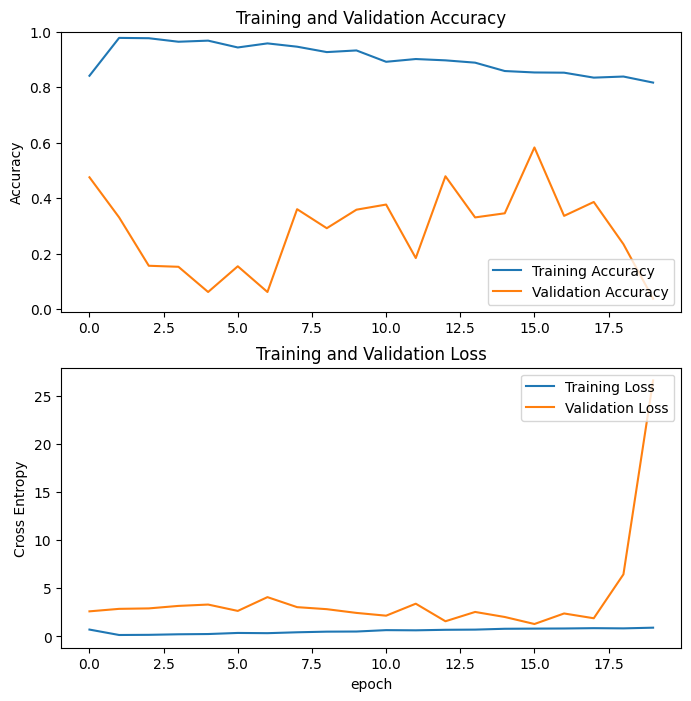

In [172]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [174]:
loss, accuracy = effnetv2_ft.evaluate(test_dataset)
print('Test accuracy :', accuracy)

17/17 [==============================] - 5s 47ms/step - loss: 26.7068 - accuracy: 0.0241
Test accuracy : 0.024118738248944283


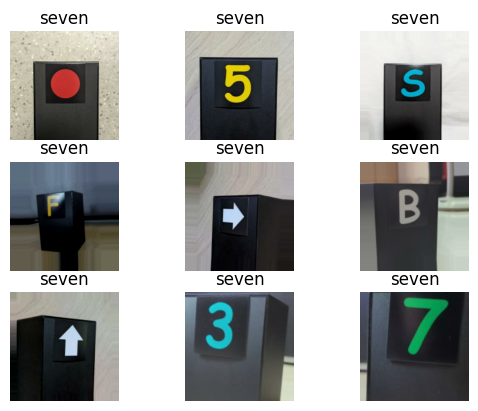

In [178]:
images, labels = next(iter(test_dataset))
preds_logits = effnetv2_ft(images)
preds = tf.math.argmax(preds_logits, 1).numpy()

for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    plt.title(classes[int(preds[i])])
    plt.axis("off")

In [179]:
preds_logits

<tf.Tensor: shape=(32, 31), dtype=float32, numpy=
array([[-22.748661  ,   1.5991052 , -14.408738  ,   8.349743  ,
        -17.839733  , -34.943615  ,  15.954174  , -18.4915    ,
        -11.606486  ,   8.1125765 , -41.141743  ,  -5.694745  ,
        -30.317625  , -17.52883   ,  -2.364039  , -37.05374   ,
         -1.9640017 , -16.117449  ,  -4.9883223 ,  -5.4596124 ,
         -3.482779  ,  10.73829   ,  -4.897838  ,  13.279088  ,
          7.3839235 , -28.989994  , -18.265867  , -27.690174  ,
        -19.517603  , -14.198797  , -25.267487  ],
       [-21.961391  ,   1.6288494 , -15.0754    ,   8.294411  ,
        -16.465704  , -35.112488  ,  15.952492  , -19.74716   ,
        -11.826566  ,   9.581045  , -40.421825  ,  -6.203665  ,
        -31.980782  , -17.100542  ,  -0.07431044, -36.976723  ,
         -1.8122096 , -17.0255    ,  -4.7401667 ,  -4.2083435 ,
         -2.9132216 ,  10.300262  ,  -6.8312926 ,  13.216392  ,
          9.612999  , -29.491718  , -18.692028  , -27.920948  ,
   